## Link Dataset:
https://www.kaggle.com/datasets/prasadvpatil/mrl-dataset

In [33]:
import kagglehub
import os

DATASET_PATH = kagglehub.dataset_download("prasadvpatil/mrl-dataset")
TRAIN_DIR = os.path.join(DATASET_PATH, "train")
print("Path to dataset files:", DATASET_PATH)

Path to dataset files: /kaggle/input/mrl-dataset


In [34]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2

BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPOCHS = 8
IMG_SIZE = 64
VAL_SPLIT = 0.2

device = "cuda" if torch.cuda.is_available() else "cpu"

In [35]:
class EyeDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("L")  # grayscale
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

In [36]:
classes = sorted(os.listdir(TRAIN_DIR))  # e.g. ["closed", "open"]
num_classes = len(classes)

image_paths = []
image_labels = []

for label_idx, label in enumerate(classes):
    class_dir = os.path.join(TRAIN_DIR, label)
    for img_file in os.listdir(class_dir):
        if img_file.lower().endswith(("png", "jpg", "jpeg")):
            image_paths.append(os.path.join(class_dir, img_file))
            image_labels.append(label_idx)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, image_labels, test_size=VAL_SPLIT, stratify=image_labels
)

print(f"Train samples: {len(train_paths)}")
print(f"Val samples:   {len(val_paths)}")

Train samples: 3200
Val samples:   800


In [37]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

In [38]:
train_dataset = EyeDataset(train_paths, train_labels, transform=train_transform)
val_dataset   = EyeDataset(val_paths, val_labels, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [39]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(128 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)


model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

Epoch 1/8 | Train Acc: 0.806, Val Acc: 0.905
Epoch 2/8 | Train Acc: 0.960, Val Acc: 0.983
Epoch 3/8 | Train Acc: 0.980, Val Acc: 0.985
Epoch 4/8 | Train Acc: 0.983, Val Acc: 0.990
Epoch 5/8 | Train Acc: 0.986, Val Acc: 0.989
Epoch 6/8 | Train Acc: 0.989, Val Acc: 0.993
Epoch 7/8 | Train Acc: 0.990, Val Acc: 0.993
Epoch 8/8 | Train Acc: 0.990, Val Acc: 0.995


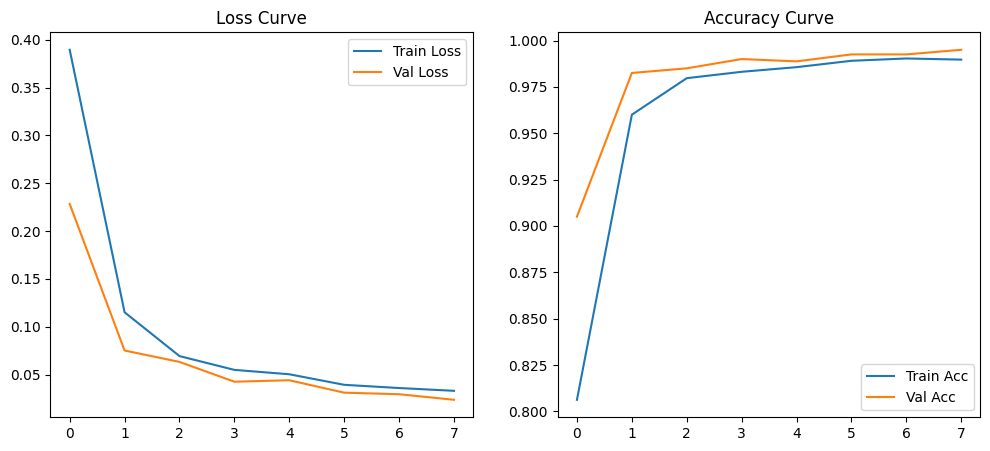

In [40]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []

def accuracy(preds, labels):
    return (preds.argmax(dim=1) == labels).float().mean().item()


for epoch in range(EPOCHS):
    model.train()
    total_loss, total_acc = 0, 0

    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, lbls)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += accuracy(outputs, lbls)

    train_losses.append(total_loss / len(train_loader))
    train_accs.append(total_acc / len(train_loader))

    # validation
    model.eval()
    val_loss, val_acc = 0, 0

    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, lbls)

            val_loss += loss.item()
            val_acc += accuracy(outputs, lbls)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_acc / len(val_loader))

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Acc: {train_accs[-1]:.3f}, Val Acc: {val_accs[-1]:.3f}")


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy Curve")
plt.legend()

plt.show()

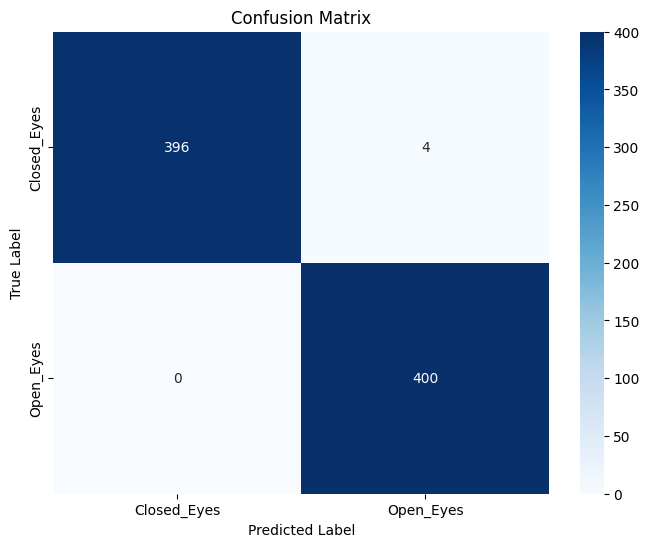

Classification Report:
               precision    recall  f1-score   support

 Closed_Eyes       1.00      0.99      0.99       400
   Open_Eyes       0.99      1.00      1.00       400

    accuracy                           0.99       800
   macro avg       1.00      0.99      0.99       800
weighted avg       1.00      0.99      0.99       800



In [41]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for imgs, lbls in val_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(lbls.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Generate Classification Report
report = classification_report(y_true, y_pred, target_names=classes)
print("Classification Report:\n", report)

In [42]:
torch.save(model.state_dict(), "eye_classifier.pth")